# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Introduction
In this capstone project, I chose to examine the Starbucks customer data because it was relevant to my interests. As a milennial who consumes Starbucks almost daily and is a user of the app, I was curious to see other customers responses to their offerings. My goal was to determine which features of the Starbucks offers factor into a customers decision to make a purchase, so I wanted to use a machine learning approach to model customer behavior trained on the data provided. There are a few steps in my approach:
1. [Data Exploration](#eda)
2. [Cleaning](#clean)
3. [Modeling](#model)
4. [Results and Conclusion](#end)

## 1. Data Exploration<a id='eda'></a>
First, we will import all of the necessary packages and load the datasets

In [84]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.pipeline import Pipeline
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

From here, we can explore the datasets and the information contained

In [85]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Initial thoughts:
   - channels and offer_type can be one hot encoded to make the variables numerical
   - change 'id' to 'offer_id' to clarify which id this refers to

In [86]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Initial thoughts:
   - In the age column, 118 doesn't really make sense for a customers age. It's also coupled with no gender as well as NaN values for income, so these rows should be further examined and perhaps dropped
   - Gender can be one hot encoded
   - became_member_on should be a datetime object instead of a numeric value

some ages dont make sense?
gender could be binary (0 for male, 1 for female)
change became member on to datetime object?

In [87]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Initial thoughts:
   - One hot encode event
   - change person to customer_id
   - Extract offer id from value column
   - Change time from hours to days

In [88]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [89]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [90]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

The amount of ages that are 118 matches the number of genders/incomes that are NaN. They are most likely linked and are invalid data.

In [91]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

## 2. Cleaning<a id='clean'></a>
The goal of cleaning these dataframes is to combine them in a way that a model can be trained on it to predict if a customer will purchase a product post offer. The two steps are to individually clean the dataframes and then combine and reorganize the master dataframe.

### I. Portfolio

In [92]:
#change id to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [93]:
# Create dummies for offer type
offer = pd.get_dummies(portfolio['offer_type'])
offer.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [94]:
# Create "dummies" for channels column with MultiLabelBinarizer()
# https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

mlb = MultiLabelBinarizer()
channels = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns = mlb.classes_, index = portfolio.index)

In [95]:
channels.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [96]:
channels.shape, offer.shape, portfolio.shape

((10, 4), (10, 3), (10, 6))

In [97]:
# Merge all dataframes together
portfolio = pd.concat([portfolio, offer, channels], axis=1, sort=False)

# Drop redundant columns
portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
portfolio.head()

,difficulty,duration,offer_id,reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


The initial cleaning gives us an entirely numerical portfolio dataframe

### II. Profile

In [98]:
# Cleaning profile
profile.head(25)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [99]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [100]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

With the analysis above, I am lead to believe that 118 is linked to invalid gender and income, so I chose to drop these rows

In [101]:
# Looks like 118 is invalid age, also has NaN salaries and no gender, so drop these
profile = profile[profile.age != 118]
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

I wanted to see the different groups that are customers of Starbucks. I chose to separate income by gender

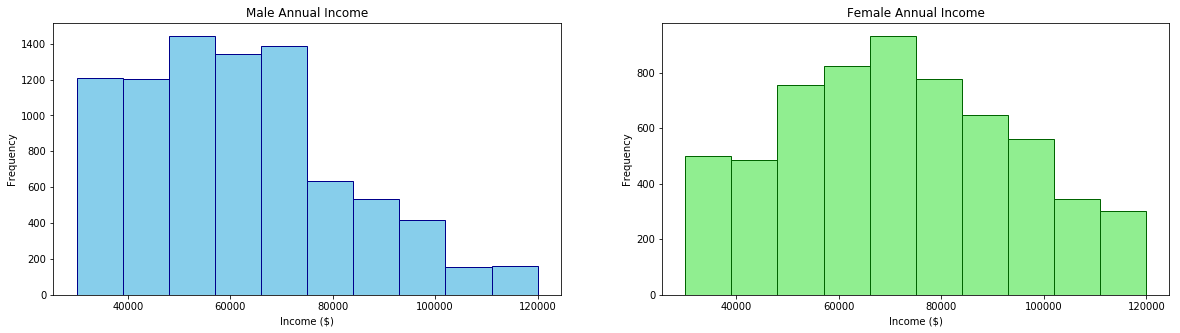

In [102]:
# Quick visualization: Income, male versus female
male = list(profile[profile['gender'] == 'M']['income'])
female = list(profile[profile['gender'] == 'F']['income'])

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(male, color = "skyblue", ec = "darkblue")
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.title('Male Annual Income')

plt.subplot(1, 2, 2)
plt.hist(female, color = "lightgreen", ec = "darkgreen")
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.title('Female Annual Income')

plt.show()

Looks like there may be a slight difference in income between genders. There is a right skew for male customers, while the female customers are more normally distributed. Median income looks to be under $80,000 for both groups, with male customers earning less than female customers.

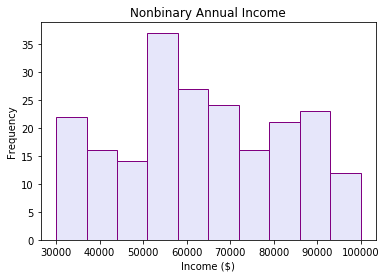

In [103]:
#  Out of interest, you can also look at other category, even though there aren't many users in that group
other = list(profile[profile['gender'] == 'O']['income'])

plt.hist(other, color = "lavender", ec = "purple")
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.title('Nonbinary Annual Income')
plt.show()

For nonbinary customers, although the pool is small, we can still observe the distribution of income. Looks like this group tends to earn less than our male and female customers. We cannot draw many valid conclusions about this spread because the group is quite small at 212 individuals, which doesn't serve well for generalizations to a larger population.

In [104]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Another visualization I was interested in was seeing when people became members

Text(0.5,1,'Date Distribution of when Users Joined')

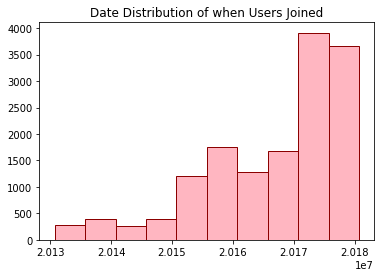

In [105]:
# Explore distribution of when users became members of Starbucks
x = list(profile['became_member_on'])
plt.hist(x, color = "lightpink", ec = "darkred")
plt.title('Date Distribution of when Users Joined')

It looks like membership is on an upwards trend since 2013. Although the app was created in 2009, it makes sense that as time goes on, more users will join via the app because of how accessible it is through mobile versus in store.

### III. Transcript

In [106]:
# Explore transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [107]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

First, let's change the person column to customer_id

In [108]:
# Remove customer ids that aren't in profile dataframe (also change person to customerid)
transcript.rename(columns={"person": "customer_id"}, inplace = True)

In [109]:
len(transcript)

306534

We should also remove customer ids that aren't in the profile dataframe because we cannot get information for these interactions

In [110]:
# Remove customerid rows that aren't in profile
transcript = transcript[transcript['customer_id'].isin(profile['id'])]
len(transcript)

272762

Next, we can extract the offer id, amount, or reward from the value column

In [111]:
# Get offer id and amount out of value column
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,customer_id,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


Notice how there are redundant offer id columns. I will 
extract all non null offer id values into a temporary column, delete the other two, 
and rename the temporary column to offer_id

In [112]:
# Check for disparities between the two offer id columns
len(transcript),transcript.offer_id.isna().sum(), transcript['offer id'].isna().sum()

(272762, 240318, 156401)

In [113]:
transcript['offer_id_temp'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# Drop redundant offer_id columns
transcript.drop(['offer id','offer_id'],axis=1, inplace=True)

# Rename offer_id column
transcript.rename(columns={'offer_id_temp':'offer_id'}, inplace=True)

transcript.head()

,event,customer_id,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


Looks like we got all of our offer ids in one place! Now we can drop the value column too

In [114]:
transcript.drop(['value'], axis = 1, inplace = True)
transcript.head()

,event,customer_id,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


Our final transcript step is to examine the distribution of offers versus transactions

In [115]:
# Event is a variable of interest
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [116]:
# Look at percentage of transactions versus offers
total = transcript.shape[0]

percent_transactions = ((transcript['event'] == 'transaction').sum() / total) * 100
percent_offers = ((total-(transcript['event'] == 'transaction').sum()) / total) * 100

print("Percentage transaction: %.1f %%" % (percent_transactions))
print("Percentage of offer events: %.1f %%" % (percent_offers))

Percentage transaction: 45.4 %
Percentage of offer events: 54.6 %


### IV. Combine and Reorganize
Here, we can separate the offers from the transactions into their own dataframes

In [117]:
offers = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]
transactions = transcript[transcript.event == 'transaction']

In [118]:
offers.head()

,event,customer_id,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [119]:
transactions.head()

,event,customer_id,time,amount,reward,offer_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


For offers, we can drop amount. For transactions, we can drop event, and offer_id

In [120]:
# Dropping above columns
offers.drop(['amount'], axis=1, inplace = True)
transactions.drop(['event','offer_id'], axis=1, inplace = True)
offers.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,customer_id,time,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [121]:
transactions.head()

,customer_id,time,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN


Now, we can get dummy variables for each type of event in the offers dataframe. Then we can rename and append them to offers

In [122]:
# Get dummies for events and append to offers
events = pd.get_dummies(offers['event'])
events.head()

,offer completed,offer received,offer viewed
0,0,1,0
2,0,1,0
5,0,1,0
7,0,1,0
8,0,1,0


In [123]:
events.rename(columns={"offer completed": "completed", "offer received": "received", "offer viewed": "viewed"}, inplace = True)

In [124]:
offers = pd.concat([offers, events], axis=1)
offers.head()

,event,customer_id,time,reward,offer_id,completed,received,viewed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [125]:
offers.drop(['event'], axis=1, inplace = True)
offers.head()

,customer_id,time,reward,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [126]:
offers.viewed.value_counts()

0    98945
1    49860
Name: viewed, dtype: int64

Now, we can change the time variables in offers and transactions from hours to days to match portfolio

In [127]:
# Convert time to days from hours
offers['time_in_hours'] = offers['time']/24
transactions['time_in_hours'] = transactions['time']/24

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
offers.drop(['time'], axis = 1, inplace = True)
transactions.drop(['time'], axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [129]:
transactions.head()

,customer_id,amount,reward,time_in_hours
12654,02c083884c7d45b39cc68e1314fec56c,0.83,NaN,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,NaN,0.0
12659,54890f68699049c2a04d415abc25e717,13.23,NaN,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,19.51,NaN,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,18.97,NaN,0.0


Here's the part where we combine the 4 dataframes (portfolio, profile, offers, and transactions) into one big master dataframe.
The goal is to be able to separate transactions that happened as a result of an offer versus transactions independent of an
offer. The function below creats new rows containing all purchase and offer information based on customer and offer ids. Ideally, we want to separate transactions that occured due to an offer from transactions independent from an offer because the goal here is to identify the effectiveness of each offer.

In [130]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

In [131]:
def combine_dfs(customer_id, portfolio, profile, offers, transactions):
    '''
    Combine customer and offer information to determine whether offers presented to customer are successful or not 
    Input: 
        customer_id: string id of customer
        portfolio: dataframe containing offer descriptions and relevant information
        profile: dataframe containing customer profiles
        offers: dataframe containing offer type and offer id associated
        transactions: dataframe containing transactions and amount associated
    Output:
        rows: list of dictionaries of success for each offer that customer receives
    '''
    customer = profile[profile['id'] == customer_id]
    
    customer_offer = offers[offers['customer_id'] == customer_id]
    customer_offer = customer_offer.drop(columns = 'customer_id').reset_index(drop = True)
    customer_trans = transactions[transactions['customer_id'] == customer_id]
    customer_trans = customer_trans.drop(columns = 'customer_id').reset_index(drop = True)
    
    received = customer_offer[customer_offer['received'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    viewed = customer_offer[customer_offer['viewed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    completed = customer_offer[customer_offer['completed'] == 1].drop(['completed', 'received', 'viewed'], axis = 1).reset_index(drop=True)
    
    rows = []
    for idx in range(len(received)):

        # Initialize the current offer id
        cur_offer_id = received.iloc[idx]['offer_id']

        # Find current offer in portfolio
        cur_offer = portfolio.loc[portfolio['offer_id'] == cur_offer_id]
        duration = cur_offer['duration'].values[0]

        # Time period when offer is valid
        startime = received.iloc[idx]['time_in_hours']

        endtime = received.iloc[idx]['time_in_hours'] + duration

        # Boolean array that falls in valid time window
        valid_transaction = np.logical_and(customer_trans['time_in_hours'] >=startime,
                           customer_trans['time_in_hours'] <= endtime)

        # Boolean array for completion of offer within time window
        valid_completed = np.logical_and(completed['time_in_hours'] >= startime,
                           completed['time_in_hours'] <= endtime)

        # Boolean array for viewing of offer within time window
        valid_viewed = np.logical_and(viewed['time_in_hours'] >= startime,
                           viewed['time_in_hours'] <= endtime)

        # Determine whether the current offer was successful
        success = valid_completed.sum() > 0 and valid_viewed.sum() > 0

        # Relevant customer transactions are ones that occurred within the current offer window
        relevant_transactions = customer_trans[valid_transaction]

        # Dictionary which describes the current customers offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': startime,
                   'success': int(success),
                   'totalamount': relevant_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the success of an offer to the customer
        rows.append(cur_row)

    return rows

In [132]:
# Test to see if function works
x = '02c083884c7d45b39cc68e1314fec56c'
#clean_data = pd.DataFrame(clean_data)
blah = pd.DataFrame(combine_dfs(x, portfolio, profile, offers, transactions))
blah.head()

,became_member_on,bogo,customerid,discount,duration,email,gender,id,income,informational,mobile,offer_id,offerid,reward,social,success,time,totalamount,web
0,20160711,1,02c083884c7d45b39cc68e1314fec56c,0,7,1,F,02c083884c7d45b39cc68e1314fec56c,30000.0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0.0,25.49,0
1,20160711,0,02c083884c7d45b39cc68e1314fec56c,1,10,1,F,02c083884c7d45b39cc68e1314fec56c,30000.0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,17.0,3.18,1


Using this function, we can create a main dataframe containing all customer and offer records, along with a variable that assigns if an offer was a success or not

In [133]:
# Using both offers and transactions, create new dataframe containing whether an offer worked or not 
starbucks_df = []
customerid_list = offers['customer_id'].unique()
for customer_id in customerid_list:
    starbucks_df.extend(combine_dfs(customer_id, portfolio, profile, offers, transactions))

In [134]:
starbucks_df = pd.DataFrame(starbucks_df)

In [135]:
starbucks_df.head()

,became_member_on,bogo,customerid,discount,duration,email,gender,id,income,informational,mobile,offer_id,offerid,reward,social,success,time,totalamount,web
0,20170509,1,78afa995795e4d85b5d9ceeca43f5fef,0,7,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,0.0,37.67,1
1,20170509,0,78afa995795e4d85b5d9ceeca43f5fef,0,3,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,1,0,7.0,49.39,0
2,20170509,1,78afa995795e4d85b5d9ceeca43f5fef,0,7,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,17.0,48.28,0
3,20170509,1,78afa995795e4d85b5d9ceeca43f5fef,0,5,1,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,21.0,48.28,1
4,20180426,0,e2127556f4f64592b11af22de27a7932,1,7,1,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,2,0,0,0.0,0.00,1


Now that the main dataframe is created, we can make some minor edits for ease of calculation

In [136]:
# Drop offer_id, id
starbucks_df.drop(['offer_id','id'], axis = 1, inplace = True)

In [137]:
# Reorder
new_order = ['customerid','offerid','success','duration','time','became_member_on','gender','income','totalamount','bogo','discount','reward','email','informational','mobile','social','web']
starbucks_df = starbucks_df.reindex(columns = new_order)

In [138]:
# Reformat became_member_on
starbucks_df['became_member_on'] = pd.to_datetime(starbucks_df['became_member_on'])

In [139]:
# Make M/F one hot encoded and drop gender
genders = pd.get_dummies(starbucks_df['gender'])

In [140]:
genders.head()

,F,M,O
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0


In [141]:
starbucks_df = pd.concat([starbucks_df, genders], axis = 1, sort = False)

In [142]:
starbucks_df.drop(['gender'], axis = 1, inplace = True)

In [143]:
starbucks_df.head()

,customerid,offerid,success,duration,time,became_member_on,income,totalamount,bogo,discount,reward,email,informational,mobile,social,web,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,7,0.0,1970-01-01 00:00:00.020170509,100000.0,37.67,1,0,5,1,0,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,3,7.0,1970-01-01 00:00:00.020170509,100000.0,49.39,0,0,0,1,1,1,1,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,7,17.0,1970-01-01 00:00:00.020170509,100000.0,48.28,1,0,10,1,0,1,1,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,5,21.0,1970-01-01 00:00:00.020170509,100000.0,48.28,1,0,5,1,0,1,1,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7,0.0,1970-01-01 00:00:00.020180426,70000.0,0.00,0,1,2,1,0,1,0,1,0,1,0


Now the dataframe is ready for the model

## 3. Modeling<a id='model'></a>

For this project, I want to see if a machine learning approach can predict whether an offer will be used for a transaction or not based on training and testing data derived from the starbucks_df dataframe I generated above. The first step would be to split the dataframe into feature data and target data. The target is if an offer is successful or not. I omitted customerid, offerid, and became_member_on because those features do not seem as if they would contribute heavily to an offers success.

In [144]:
# Split into training and testing data
features = starbucks_df[['duration','time','income','totalamount','bogo','discount','reward','email','informational','mobile','social','web', 'F','M','O']]
target = starbucks_df['success']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

In [146]:
X_train.head()

,duration,time,income,totalamount,bogo,discount,reward,email,informational,mobile,social,web,F,M,O
25876,7,7.0,52000.0,33.62,0,1,3,1,0,1,1,1,0,1,0
2034,7,7.0,101000.0,20.39,0,1,2,1,0,1,0,1,1,0,0
1899,7,0.0,64000.0,22.88,0,1,3,1,0,1,1,1,1,0,0
12234,10,7.0,35000.0,2.24,0,1,2,1,0,1,1,1,0,1,0
17486,4,24.0,36000.0,5.21,0,0,0,1,1,1,0,1,1,0,0


In [147]:
y_train.value_counts()

0    28137
1    25063
Name: success, dtype: int64

I was interested in the difference between using a decision tree classifer versus a random forest classifer for this model. The article below helped me understand how each classifier works in depth.
https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991

In [148]:
clf1 = DecisionTreeClassifier()                
clf2 = RandomForestClassifier()
classifier_list = [clf1,clf2]

I decided to look at the F1 score to determine which classifer to use.

> $ F1 = 2 * (precision * recall) / (precision + recall) $

F1 scores are a measure that looks at both the precision and the recall of the classifer

In [149]:
clf_dict = {}
for clf in classifier_list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test, y_pred)
    clf_dict[clf.__class__.__name__] = accuracy

In [150]:
print(clf_dict)

{'DecisionTreeClassifier': 0.86843564356435654, 'RandomForestClassifier': 0.89093360831284218}


I decided to go with the random forest classifer because it has a higher F1 score. Next, we can conduct grid search to optimize the model

In [151]:
parameters = {#'clf__estimator__n_estimators': [10]
             'n_estimators': [5,10],
            'min_samples_split': [2,3,4]}
             #'clf__estimator__min_samples_split': [2,3]}

cv = GridSearchCV(estimator = clf2, param_grid = parameters)

In [152]:
cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [153]:
print('Training F1_score:', cv.score(X_train,y_train))
print('Test F1_score:', cv.score(X_test,y_test))

Training F1_score: 0.976184210526
Test F1_score: 0.902187805428


Here we can see that the F1 scores have jumped to 0.97 for the training data and 0.90 for the testing data

I wanted to know which feature contributed the most to an offers success or failure. I found this website to be helpful in calculating how important a feature is for this classification
https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

In [154]:
cv.best_estimator_.feature_importances_

array([  6.56297564e-02,   2.47173357e-02,   9.40936324e-02,
         6.57409347e-01,   2.47546967e-03,   1.18238138e-02,
         6.02676703e-02,   0.00000000e+00,   3.78308970e-02,
         5.56895081e-03,   2.09517683e-02,   9.98292548e-03,
         1.77423972e-03,   6.97065911e-03,   5.03534684e-04])

In [155]:
feature_importances = pd.DataFrame(cv.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [156]:
feature_importances

,importance
totalamount,0.657409
income,0.094094
duration,0.065630
reward,0.060268
informational,0.037831
time,0.024717
social,0.020952
discount,0.011824
web,0.009983
M,0.006971


In [157]:
feature_importances.importance

totalamount      0.657409
income           0.094094
duration         0.065630
reward           0.060268
informational    0.037831
time             0.024717
social           0.020952
discount         0.011824
web              0.009983
M                0.006971
mobile           0.005569
bogo             0.002475
F                0.001774
O                0.000504
email            0.000000
Name: importance, dtype: float64

In [158]:
feature_importances.index

Index(['totalamount', 'income', 'duration', 'reward', 'informational', 'time',
       'social', 'discount', 'web', 'M', 'mobile', 'bogo', 'F', 'O', 'email'],
      dtype='object')

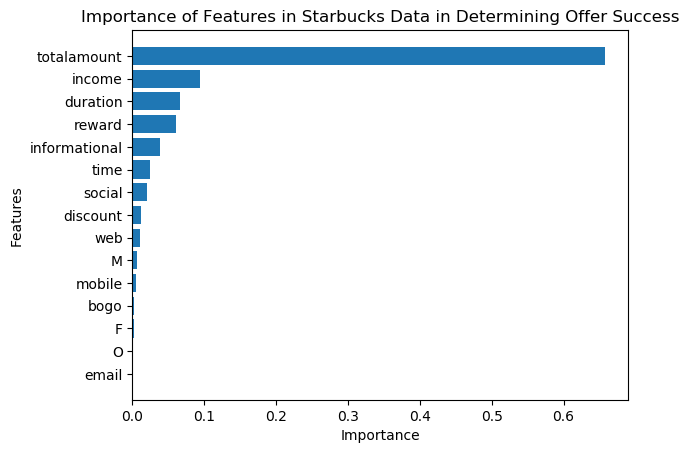

In [159]:
plt.rcdefaults()
fig, ax = plt.subplots()

imp_features = list(feature_importances.index)
y_pos = np.arange(len(imp_features))
importance = list(feature_importances.importance)

ax.barh(y_pos, importance,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_features)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Importance of Features in Starbucks Data in Determining Offer Success')

plt.show()

It looks like the total amount spent in transactions affects the offer success the most. This feature takes up the majority of the importance, but is followed by income and offer duration.

In [160]:
def save_model(model, model_filepath):
    '''
    Save model as a pickle file 
    Input: 
        model: evaluated model
        model_filepath: path of the output file
    Output:
        A pickle file of saved model
    '''
    pickle.dump(model, open(model_filepath, "wb"))

In [161]:
model_filepath = 'randomforestclassifer.pkl'
print('Saving model...\n    MODEL: {}'.format(model_filepath))
save_model(cv, model_filepath)

Saving model...
    MODEL: randomforestclassifer.pkl


## 4. Results and Conclusion<a id='end'></a>

Based on the model above, it looks like the most influential factor in determining whether an offer will be successful or not was the amount of money a customer has spent on transactions. Logically, this makes sense, as a customer will most likely be thinking about how much money they have spent on previous purchases. However, the model doesn't tell us whether high spenders or budgeters are more likely to make a transaction based on an offer. In the future, a feature categorizing high to moderate to low spenders based on the totalamount column could help elucidate this. Starbucks could even implement this feature to target high spending or low spending customers.

The data itself could be diversified as well. Whether users purchase items via the app or in store could be an interesting variable to determine if offers are being used in transactions. Regional data could also be useful, as some Starbucks don't accept the same offers as others, even if a customer receives an offer, which could count as an unsuccessful offer even if the customer was attempting to use the offer. Regional data may also affect customer profile data as well.

Overall, the data allowed us to make some interesting discoveries regarding what influences an offer acceptance to turn into a successful transaction.

## Acknowledgements and Links
Thank you to the Udacity team and my mentor Mrudula for the lessons and guidance
Thank you to Starbucks for providing the data for this project

https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies

https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991

https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e